In [17]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from lineartree           import LinearBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import datetime as dt

In [18]:
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

In [350]:
bike_train = pd.read_excel('./bike_train.xlsx')
bike_test = pd.read_excel('./bike_test.xlsx')

In [351]:
bike_train.drop(columns=['instant', 'yr', 'mnth', 'hr'], axis=1, inplace=True)
#bike_train.set_index('dteday', inplace=True)

In [352]:
bike_test.drop(columns=['instant', 'yr', 'mnth', 'hr'], axis=1, inplace=True)
#bike_test.set_index('dteday', inplace=True)

In [353]:
bike_train.head()

,dteday,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,1,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01,1,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01,1,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01,1,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [354]:
bike_test.head()

,dteday,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,2012-05-20,2,0,0,0,1,0.52,0.5000,0.68,0.0896
1,2012-05-20,2,0,0,0,1,0.50,0.4848,0.72,0.1045
2,2012-05-20,2,0,0,0,1,0.50,0.4848,0.63,0.1343
3,2012-05-20,2,0,0,0,1,0.52,0.5000,0.68,0.1940
4,2012-05-20,2,0,0,0,1,0.56,0.5303,0.56,0.1642


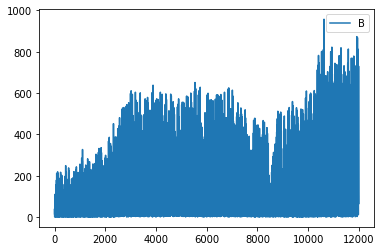

In [355]:
bike_train['cnt'].plot(legend=True)
plt.legend('Bike training')
plt.show()

In [396]:
Q1 = np.percentile(bike_train['cnt'], 25,
                method='midpoint')

Q3 = np.percentile(bike_train['cnt'], 75,
                method='midpoint')
IQR = Q3 - Q1

# Upper bound
upper = np.where(bike_train['cnt'] >= (Q3 + 1.5 * IQR))
# Lower bound
lower = np.where(bike_train['cnt'] <= (Q1 - 1.5 * IQR))

bike_train.drop(upper[0], inplace=True)
bike_train.drop(lower[0], inplace=True)
bike_train.reset_index(drop=True, inplace=True)

KeyError: '[447, 504] not found in axis'

Downsample

In [357]:
bike_train = bike_train.groupby('dteday')[['holiday', 'weekday', 'workingday', 'temp', 'atemp', 'hum', 'cnt']].sum()

In [358]:
0.75 * bike_train.shape[0]

379.5

In [359]:
train_df, test_df = bike_train[1:380], bike_train[380:]

In [360]:
bike_test = bike_test.groupby('dteday')[['holiday', 'weekday', 'workingday', 'temp', 'atemp', 'hum']].sum()
bike_test.head()

,holiday,weekday,workingday,temp,atemp,hum
dteday,,,,,,
2012-05-20,0,0,0,12.66,11.8939,10.60
2012-05-21,0,24,24,14.36,13.5760,19.47
2012-05-22,0,48,24,14.76,13.9398,18.38
2012-05-23,0,72,24,14.92,14.0307,18.59
2012-05-24,0,96,24,15.72,14.5608,17.20


In [361]:
test_df.head()

,holiday,weekday,workingday,temp,atemp,hum,cnt
dteday,,,,,,,
2012-01-16,24,24,0,4.56,4.5759,12.54,2298
2012-01-17,0,46,23,8.58,8.3784,16.47,2935
2012-01-18,0,72,24,7.28,6.6061,10.64,3376
2012-01-19,0,96,24,4.56,4.5609,11.94,3292
2012-01-20,0,120,24,5.22,5.3030,10.80,3163


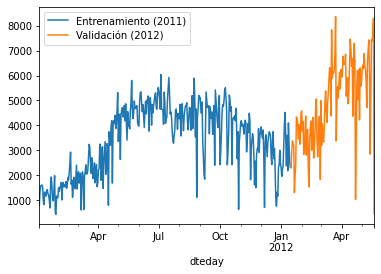

In [362]:
train_df['cnt'].plot(legend=True)
test_df['cnt'].plot(legend=True)
plt.legend(['Entrenamiento (2011)', 'Validación (2012)'])
plt.show()

In [363]:
scal = MinMaxScaler(feature_range=(0, 1))
scale_train = scal.fit_transform(train_df)

In [364]:
# La red LSTM tendrá como entrada "time_step" datos consecutivos, 
# y como salida 1 dato (la predicción a partir de esos "time_step" datos). 
# Se conformará de esta forma el set de entrenamiento
time_step = 60
X_train = []
Y_train = []
m = len(scale_train)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(scale_train[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(scale_train[i,0])

In [365]:
X_train, Y_train = np.array(X_train), np.array(Y_train)
# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [366]:
# Red LSTM
#
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 100

modelo = tf.keras.models.Sequential()
modelo.add(tf.keras.layers.LSTM(units=na, input_shape=dim_entrada))
modelo.add(tf.keras.layers.Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse',
                 metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
modelo.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 100)               40800     
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [367]:
print(bike_train.shape[0] % 51)

47


In [368]:
modelo.fit(X_train,Y_train,epochs=20,batch_size=51)

Epoch 1/20
7/7 [==============================] - 5s 64ms/step - loss: 0.0277 - rmse: 0.1664
Epoch 2/20
7/7 [==============================] - 0s 61ms/step - loss: 0.0270 - rmse: 0.1642
Epoch 3/20
7/7 [==============================] - 0s 61ms/step - loss: 0.0272 - rmse: 0.1649
Epoch 4/20
7/7 [==============================] - 0s 60ms/step - loss: 0.0269 - rmse: 0.1640
Epoch 5/20
7/7 [==============================] - 0s 62ms/step - loss: 0.0270 - rmse: 0.1644
Epoch 6/20
7/7 [==============================] - 0s 59ms/step - loss: 0.0270 - rmse: 0.1644
Epoch 7/20
7/7 [==============================] - 0s 59ms/step - loss: 0.0272 - rmse: 0.1649
Epoch 8/20
7/7 [==============================] - 0s 55ms/step - loss: 0.0268 - rmse: 0.1638
Epoch 9/20
7/7 [==============================] - 0s 57ms/step - loss: 0.0269 - rmse: 0.1639
Epoch 10/20
7/7 [==============================] - 0s 62ms/step - loss: 0.0269 - rmse: 0.1639
Epoch 11/20
7/7 [==============================] - 0s 66ms/step - los

In [370]:
bike_test['cnt'] = 0

In [385]:
# Validación (predicción del valor de las acciones)
#
x_test = test_df.values
x_test = scal.transform(x_test)

c:\Users\cajas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [386]:
X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [387]:
X_test.shape

(66, 60, 1)

In [389]:
prediccion = modelo.predict(X_test)
#prediccion = scal.inverse_transform(prediccion)

3/3 [==============================] - 0s 9ms/step


In [390]:
# create empty table with 12 fields
trainPredict_dataset = np.zeros(shape=(len(prediccion), 7) )
# put the predicted values in the right field
trainPredict_dataset[:,0] = prediccion[:,0]
# inverse transform and then select the right field
prediccion = scal.inverse_transform(trainPredict_dataset)[:,0]